In [ ]:
#!pip install -Uqq wandb
#!wandb login dada17887d4a4c82baeb59905969b7614d892bde

In [1]:
!nvidia-smi

Sun Sep 25 14:30:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0  On |                  N/A |
|  0%   45C    P8    38W / 350W |    120MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%env WANDB_SILENT=true

env: WANDB_SILENT=true


In [3]:
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold
from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm
from timm.models import safe_model_name, set_fast_norm
from fastai.callback.wandb import WandbCallback
import wandb

In [97]:
import IPython.display as disp

In [82]:
warnings.filterwarnings('ignore')

## Configuration

In [43]:
EXP_NAME = "EXP_001_convnext-t_224"

WANDB_PROJECT = 'kaggle-corn-2022'

CSV_PATH = Path('/data/train.csv')
DATA_PATH = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

MODEL_NAME     = "convnext_tiny_in22ft1k"
GLOBAL_POOL    = "avg"
BATCH_SIZE     = 64
N_EPOCHS       = 10
INPUT_SZ       = 224
FAST_NORM      = True
DROP_RATE      = 0.5
DROP_PATH_RATE = 0.1

In [7]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [8]:
folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
#print(folds.groupby(['fold', "label"]).size())

In [9]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())

def timm_params(timm_model, cut=-1):
    body_param_names = timm_get_param_names(timm_model)
    head_param_names = L(body_param_names.pop(-1)).concat()
    
    body_param_names = L(body_param_names[:cut].concat(), body_param_names[cut:].concat())
    return body_param_names, head_param_names

def timm_splitter(m, cut=-1):
    "Splitter function for timm models"
    body_param_names, head_param_names = timm_params(m, cut)
    param_groups = [g.map(m.get_parameter) for g in body_param_names]
    param_groups.append([m.get_parameter(p) for p in head_param_names])
    return param_groups

In [34]:
def get_datasets(fold: int = 0):
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter=IndexSplitter(fold_splits[fold]),
        get_x=ColReader(0, pref=DATA_PATH),
        get_y=ColReader(1),
        item_tfms=RandomResizedCrop(INPUT_SZ, min_scale=0.35),
        batch_tfms=[
            *aug_transforms(
                flip_vert=True, 
                pad_mode=PadMode.Zeros, 
                max_rotate=360, 
                max_zoom=1.3, 
                max_lighting=0.1,
                p_lighting=0.5, 
                xtra_tfms=[RandomErasing(p=0.75)]),
            Normalize.from_stats(*imagenet_stats)])
    
    dls = dblock.dataloaders(folds[["image", "label"]], bs=BATCH_SIZE)
    return dls

## Visualize

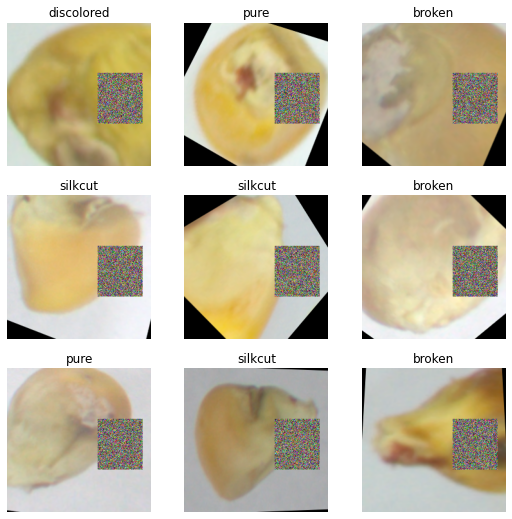

In [40]:
dls = get_datasets()
dls.train.show_batch()

In [58]:
def get_model(dls, pretrained=True):
    set_fast_norm(enable=FAST_NORM)
    
    model = timm.create_model(
        MODEL_NAME,
        pretrained=pretrained,
        global_pool=GLOBAL_POOL,
        drop_rate=DROP_RATE, 
        drop_path_rate=DROP_PATH_RATE,
        num_classes=dls.c)
    return model

In [59]:
 def run_fit(KFOLD: int, lr_find: bool = False, learning_rate: float = 3e-04):
    set_seed(42)
    
    dls = get_datasets(KFOLD)
    
    model = get_model(dls, pretrained=True)

    learn = Learner(dls, model, splitter=partial(timm_splitter, cut=-3), metrics=[accuracy]).to_fp16()
    
    if lr_find:
        print("Only Running Lr Finder ...")
        suggest = learn.lr_find()
        print("* Suggestion: ", suggest)
        return suggest

    learn.fine_tune(N_EPOCHS, learning_rate,
                    cbs=[SaveModelCallback(monitor="accuracy", comp=np.greater, fname="model"), 
                         WandbCallback(log=None, log_preds=False)])

    learn = learn.load("model")
    learn = learn.to_fp32()
    
    dirpath = Path("/runs") / f"{EXP_NAME}_CV_{KFOLD:02d}.pth"
    torch.save(learn.model.state_dict(), dirpath)
    
    print(f'Best model saved to {dirpath!r} ...')

## LR Finder


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,096  11,107  15,898 MB  19.48% 
GPU:   1,625  22,950  24,576 MB   6.62% 




Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_1k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_22k_1k_224.pth


Only Running Lr Finder ...


* Suggestion:  SuggestedLRs(valley=0.0003311311302240938)
CPU: 795/0/3892 MB | GPU: 264/4150/1889 MB | Time 0:00:29.813 | (Consumed/Peaked/Used Total)

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:00:30 (elapsed wallclock time)

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:      795        0 MB (  0.00%)
GPU:      264        0 MB (  0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,892  10,509  15,898 MB  24.48% 
GPU:   1,889  22,686  24,576 MB   7.69% 




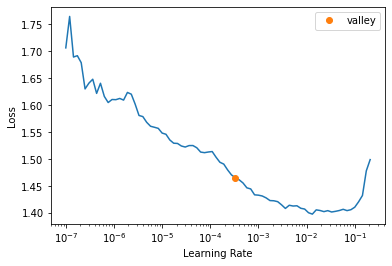

In [46]:
with IPyExperimentsPytorch(cl_set_seed=42):
    run_fit(0, lr_find=True)

## Finetune Pretrained

In [49]:
for fold_idx in range(5):
    with IPyExperimentsPytorch(cl_set_seed=42):
        with wandb.init(project=WANDB_PROJECT, group=EXP_NAME, name=f"{EXP_NAME}/CV_{fold_idx:02d}"):
            run_fit(fold_idx, lr_find=False, learning_rate=4e-03)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,735  10,649  15,898 MB  23.49% 
GPU:   1,851  22,724  24,576 MB   7.53% 




epoch,train_loss,valid_loss,accuracy,time
0,1.160830,0.854709,0.648517,00:23


Better model found at epoch 0 with accuracy value: 0.6485165953636169.


epoch,train_loss,valid_loss,accuracy,time
0,0.921830,0.674652,0.734380,00:29
1,0.806764,0.618547,0.747993,00:29
2,0.763191,0.581346,0.771728,00:29
3,0.743548,0.574740,0.779756,00:30
4,0.717244,0.540382,0.785340,00:29
5,0.677156,0.529337,0.787435,00:30
6,0.633950,0.522279,0.782548,00:30
7,0.591970,0.526040,0.789878,00:30
8,0.592448,0.512930,0.795462,00:30
9,0.561765,0.515300,0.791274,00:30


Better model found at epoch 0 with accuracy value: 0.7343804240226746.
Better model found at epoch 1 with accuracy value: 0.747992992401123.
Better model found at epoch 2 with accuracy value: 0.7717277407646179.
Better model found at epoch 3 with accuracy value: 0.7797556519508362.
Better model found at epoch 4 with accuracy value: 0.7853403091430664.
Better model found at epoch 5 with accuracy value: 0.7874345779418945.
Better model found at epoch 7 with accuracy value: 0.7898778319358826.
Better model found at epoch 8 with accuracy value: 0.7954624891281128.


/opt/conda/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Best model saved to Path('/runs/EXP_001_convnext-t_224_CV_00.pth') ...
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:05:43.674
･ CPU:         54        171      3,789 MB |
･ GPU:          2      4,176      1,853 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:05:44 (elapsed wallclock time)

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:       54        0 MB (  0.00%)
GPU:        2        0 MB (  0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,789  10,507  15,898 MB  23.83% 
GPU:   1,853  22,722  24,576 MB   7.54% 



*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,789  10,507  15,898 MB  23.83% 
GPU:   1,853  22,722  24,576 MB   7.54% 




epoch,train_loss,valid_loss,accuracy,time
0,1.165296,0.819666,0.658290,00:23


Better model found at epoch 0 with accuracy value: 0.6582897305488586.


epoch,train_loss,valid_loss,accuracy,time
0,0.928519,0.698661,0.707853,00:30
1,0.810108,0.602652,0.765794,00:30
2,0.762984,0.597156,0.760908,00:30
3,0.739199,0.553934,0.775567,00:30
4,0.712861,0.587716,0.773822,00:30
5,0.678969,0.517629,0.796859,00:30
6,0.641695,0.496643,0.800349,00:30
7,0.597980,0.502537,0.803141,00:30
8,0.582961,0.497272,0.801047,00:30
9,0.575769,0.494388,0.804188,00:30


Better model found at epoch 0 with accuracy value: 0.707853376865387.
Better model found at epoch 1 with accuracy value: 0.765794038772583.
Better model found at epoch 3 with accuracy value: 0.7755671739578247.
Better model found at epoch 5 with accuracy value: 0.7968586683273315.
Better model found at epoch 6 with accuracy value: 0.8003490567207336.
Better model found at epoch 7 with accuracy value: 0.8031413555145264.
Better model found at epoch 9 with accuracy value: 0.8041884899139404.


/opt/conda/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Best model saved to Path('/runs/EXP_001_convnext-t_224_CV_01.pth') ...
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:05:39.960
･ CPU:         67        116      3,856 MB |
･ GPU:         -2      4,216      1,851 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:05:40 (elapsed wallclock time)

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:      -32        0 MB ( -0.00%)
GPU:       -2        0 MB ( -0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,756  10,525  15,898 MB  23.63% 
GPU:   1,851  22,724  24,576 MB   7.53% 



*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,756  10,524  15,898 MB  23.63% 
GPU:   1,851  22,724  24,576 MB   7.53% 




epoch,train_loss,valid_loss,accuracy,time
0,1.146541,0.899242,0.636522,00:23


Better model found at epoch 0 with accuracy value: 0.6365223526954651.


epoch,train_loss,valid_loss,accuracy,time
0,0.908525,0.681982,0.711592,00:30
1,0.795536,0.667509,0.720670,00:30
2,0.750361,0.590750,0.756634,00:30
3,0.752829,0.607722,0.761522,00:30
4,0.705385,0.561316,0.778282,00:30
5,0.668790,0.540887,0.795740,00:30
6,0.626673,0.539486,0.799232,00:30
7,0.594468,0.518984,0.797835,00:30
8,0.571418,0.528558,0.795391,00:30
9,0.564752,0.508747,0.804120,00:30


Better model found at epoch 0 with accuracy value: 0.7115921974182129.
Better model found at epoch 1 with accuracy value: 0.7206704020500183.
Better model found at epoch 2 with accuracy value: 0.7566340565681458.
Better model found at epoch 3 with accuracy value: 0.7615223526954651.
Better model found at epoch 4 with accuracy value: 0.778282105922699.
Better model found at epoch 5 with accuracy value: 0.7957402467727661.
Better model found at epoch 6 with accuracy value: 0.7992318272590637.
Better model found at epoch 9 with accuracy value: 0.8041201233863831.


/opt/conda/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Best model saved to Path('/runs/EXP_001_convnext-t_224_CV_02.pth') ...
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:05:39.982
･ CPU:         49        168      3,805 MB |
･ GPU:          4      4,214      1,855 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:05:40 (elapsed wallclock time)

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:       49        0 MB (  0.00%)
GPU:        4        0 MB (  0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,805  10,526  15,898 MB  23.94% 
GPU:   1,855  22,720  24,576 MB   7.55% 



*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,805  10,526  15,898 MB  23.94% 
GPU:   1,855  22,720  24,576 MB   7.55% 




epoch,train_loss,valid_loss,accuracy,time
0,1.185894,0.846363,0.662360,00:23


Better model found at epoch 0 with accuracy value: 0.6623603105545044.


epoch,train_loss,valid_loss,accuracy,time
0,0.905818,0.631957,0.743715,00:30
1,0.805862,0.614004,0.757332,00:30
2,0.779598,0.533888,0.790852,00:30
3,0.743113,0.555217,0.777584,00:30
4,0.706987,0.525763,0.789455,00:30
5,0.675113,0.518085,0.790154,00:30
6,0.645339,0.498741,0.796089,00:30
7,0.609128,0.477941,0.807263,00:30
8,0.586173,0.469825,0.812849,00:30
9,0.586367,0.469477,0.813897,00:30


Better model found at epoch 0 with accuracy value: 0.7437151074409485.
Better model found at epoch 1 with accuracy value: 0.7573323845863342.
Better model found at epoch 2 with accuracy value: 0.7908519506454468.
Better model found at epoch 6 with accuracy value: 0.7960894107818604.
Better model found at epoch 7 with accuracy value: 0.8072625994682312.
Better model found at epoch 8 with accuracy value: 0.8128491640090942.
Better model found at epoch 9 with accuracy value: 0.813896656036377.


/opt/conda/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Best model saved to Path('/runs/EXP_001_convnext-t_224_CV_03.pth') ...
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:05:40.234
･ CPU:        -15        169      3,789 MB |
･ GPU:         -2      4,214      1,853 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:05:41 (elapsed wallclock time)

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:      -15        0 MB ( -0.00%)
GPU:       -2        0 MB ( -0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,789  10,531  15,898 MB  23.84% 
GPU:   1,853  22,722  24,576 MB   7.54% 



*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,789  10,531  15,898 MB  23.84% 
GPU:   1,853  22,722  24,576 MB   7.54% 




epoch,train_loss,valid_loss,accuracy,time
0,1.171049,0.826097,0.671439,00:23


Better model found at epoch 0 with accuracy value: 0.6714385747909546.


epoch,train_loss,valid_loss,accuracy,time
0,0.924605,0.768501,0.695880,00:30
1,0.808135,0.572111,0.765363,00:30
2,0.756017,0.564779,0.769553,00:30
3,0.756287,0.579088,0.755587,00:30
4,0.711973,0.588607,0.779679,00:30
5,0.669141,0.526841,0.796439,00:30
6,0.646699,0.476489,0.804818,00:30
7,0.604505,0.477876,0.811802,00:30
8,0.601834,0.465916,0.814944,00:30
9,0.575932,0.463687,0.815293,00:30


Better model found at epoch 0 with accuracy value: 0.6958798766136169.
Better model found at epoch 1 with accuracy value: 0.7653631567955017.
Better model found at epoch 2 with accuracy value: 0.7695530652999878.
Better model found at epoch 4 with accuracy value: 0.7796787619590759.
Better model found at epoch 5 with accuracy value: 0.7964385747909546.
Better model found at epoch 6 with accuracy value: 0.8048184514045715.
Better model found at epoch 7 with accuracy value: 0.8118016719818115.
Better model found at epoch 8 with accuracy value: 0.8149441480636597.
Better model found at epoch 9 with accuracy value: 0.8152933120727539.


/opt/conda/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Best model saved to Path('/runs/EXP_001_convnext-t_224_CV_04.pth') ...
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:05:39.909
･ CPU:        -15        185      3,774 MB |
･ GPU:         -2      4,176      1,851 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:05:40 (elapsed wallclock time)

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:      -15        0 MB ( -0.00%)
GPU:       -2        0 MB ( -0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   3,774  10,544  15,898 MB  23.74% 
GPU:   1,851  22,724  24,576 MB   7.53% 




## OOF Score Validation

In [99]:
pattern = f"{EXP_NAME}_CV_" + "{fold:02d}"
folds_val_score = []

with IPyExperimentsPytorch(cl_set_seed=42):
    for fold_index in range(5):
        checkpoint = pattern.format(fold=fold_index)

        dls = get_datasets(fold_index)
        model = get_model(dls, pretrained=False)

        learn = Learner(dls, model, metrics=[accuracy], model_dir=Path("/runs/"))
        learn.load(checkpoint)

        preds, targs = learn.get_preds(dl=dls.valid)
        acc = accuracy(preds, targs).item()
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (w/o TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (w/o TTA) ============
folds score:  [0.79581, 0.80489, 0.80482, 0.8132, 0.81494]
Avg: 0.80673
Std: 0.00686


In [205]:
# pattern = f"{EXP_NAME}_CV_" + "{fold:02d}"
# folds_val_score = []

# with IPyExperimentsPytorch(cl_set_seed=42):
#     for fold_index in range(5):
#         checkpoint = pattern.format(fold=fold_index)

#         dls = get_datasets(fold_index)
#         model = get_model(dls, pretrained=False)

#         learn = Learner(dls, model, metrics=[accuracy], model_dir=Path("/runs/"))
#         learn.load(checkpoint)

#         preds, targs = learn.tta(dl=dls.valid, n=8, beta=1/4)
#         acc = accuracy(preds, targs).item()
#         folds_val_score.append(acc)

# disp.clear_output()    
# print("============ Run summary (4x TTA) ============")
# print("folds score: ", [np.round(s, 5) for s in folds_val_score])
# print("Avg: {:.5f}".format(np.mean(folds_val_score)))
# print("Std: {:.5f}".format(np.std(folds_val_score)))

In [206]:
# pattern = f"{EXP_NAME}_CV_" + "{fold:02d}"
# folds_val_score = []

# with IPyExperimentsPytorch(cl_set_seed=42):
#     for fold_index in range(5):
#         checkpoint = pattern.format(fold=fold_index)

#         dls = get_datasets(fold_index)
#         model = get_model(dls, pretrained=False)

#         learn = Learner(dls, model, metrics=[accuracy], model_dir=Path("/runs/"))
#         learn.load(checkpoint)

#         preds, targs = learn.tta(dl=dls.valid, n=8, beta=1/8)
#         acc = accuracy(preds, targs).item()
#         folds_val_score.append(acc)

# disp.clear_output()    
# print("============ Run summary (8x TTA) ============")
# print("folds score: ", [np.round(s, 5) for s in folds_val_score])
# print("Avg: {:.5f}".format(np.mean(folds_val_score)))
# print("Std: {:.5f}".format(np.std(folds_val_score)))

In [202]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

In [204]:
pattern = f"{EXP_NAME}_CV_" + "{fold:02d}"
folds_val_score = []

with IPyExperimentsPytorch(cl_set_seed=42):
    for fold_index in range(5):
        checkpoint = pattern.format(fold=fold_index)

        dls = get_datasets(fold_index)
        model = get_model(dls, pretrained=False)

        learn = Learner(dls, model, metrics=[accuracy], model_dir=Path("/runs/"))
        learn.load(checkpoint)
        
        tst_dl = dls.valid.new(
            after_item=dls.valid.after_item, 
            after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)])
        
        tst_dl_1 = dls.valid.new(
            after_item=dls.valid.after_item, 
            after_batch=[IntToFloatTensor(), hflip, Normalize.from_stats(*imagenet_stats)])

        tst_dl_2 = dls.valid.new(
            after_item=dls.valid.after_item, 
            after_batch=[IntToFloatTensor(), vflip, Normalize.from_stats(*imagenet_stats)])
        
        with learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
            preds1, _ = learn.get_preds(dl=tst_dl_1)
            preds2, _ = learn.get_preds(dl=tst_dl_2)
            
        preds = (preds0+preds1+preds2)/3
        
        acc = accuracy(preds, targs).item()
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.80035, 0.80489, 0.80796, 0.81425, 0.81494]
Avg: 0.80848
Std: 0.00556
